## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

## Load Dataset

In [2]:
df=pd.read_csv('bbc_news_full.csv')

## Explore & Understand the Data

In [3]:
df.shape

(2225, 3)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        2225 non-null   object
 1   label       2225 non-null   int64 
 2   label_text  2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [5]:
df.head()

,text,label,label_text
0,wales want rugby league training wales could f...,2,sport
1,china aviation seeks rescue deal scandal-hit j...,1,business
2,rock band u2 break ticket record u2 have smash...,3,entertainment
3,markets signal brazilian recovery the brazilia...,1,business
4,tough rules for ringtone sellers firms that fl...,0,tech


In [6]:
df['label_text'].value_counts()

label_text
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [7]:
df.isnull().sum()

text          0
label         0
label_text    0
dtype: int64

## Create Modeling Dataset for LDA

In [8]:
sub_df=df.drop(columns=['label','label_text'])
sub_df

,text
0,wales want rugby league training wales could f...
1,china aviation seeks rescue deal scandal-hit j...
2,rock band u2 break ticket record u2 have smash...
3,markets signal brazilian recovery the brazilia...
4,tough rules for ringtone sellers firms that fl...
...,...
2220,mobile multimedia slow to catch on there is no...
2221,owen determined to stay in madrid england forw...
2222,mobile tv tipped as one to watch scandinavians...
2223,stormy year for property insurers a string of ...


## Text Preprocessing

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

sub_df['clean_text'] = sub_df['text'].apply(clean_text)

## Feature Extraction

In [10]:
count_vectorizer=CountVectorizer(stop_words='english', max_df=0.95, min_df=10)

In [11]:
dtm=count_vectorizer.fit_transform(sub_df['clean_text'])

## Train LDA 

In [13]:
lda=LatentDirichletAllocation(n_components=5,random_state=42)

lda.fit(dtm)

,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


## Extract and Display Top Keywords for Each Topic

In [14]:
def print_topics(model, feature_names, top_n=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx + 1}:")
        print(" ".join(
            feature_names[i]
            for i in topic.argsort()[-top_n:][::-1]
        ))

feature_names = count_vectorizer.get_feature_names_out()
print_topics(lda, feature_names)



Topic 1:
film best said music year new awards award won years

Topic 2:
said mr government labour people election party blair minister new

Topic 3:
said game england win world time play club players just

Topic 4:
said bn china company oil court bank firm london case

Topic 5:
said people year new market technology mr mobile uk sales


## Assign Dominant Topic to Each Document

In [15]:
topic_distribution = lda.transform(dtm)
sub_df['dominant_topic'] = topic_distribution.argmax(axis=1)


## Assign Semantic Labels to LDA Topics

In [16]:
topic_names = {
    0: "Entertainment & Film Awards",
    1: "Politics & Government",
    2: "Sports & Games",
    3: "Business, Finance & Legal Affairs",
    4: "Technology & Market Trends"
}
sub_df['topic_name'] = sub_df['dominant_topic'].map(topic_names)


## Topic Visualization with Word Clouds

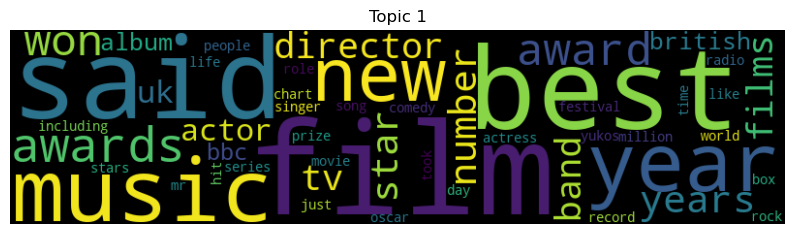

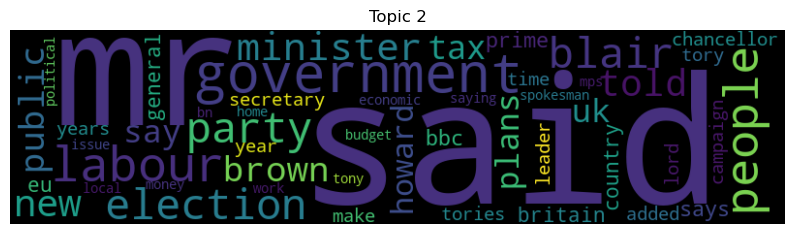

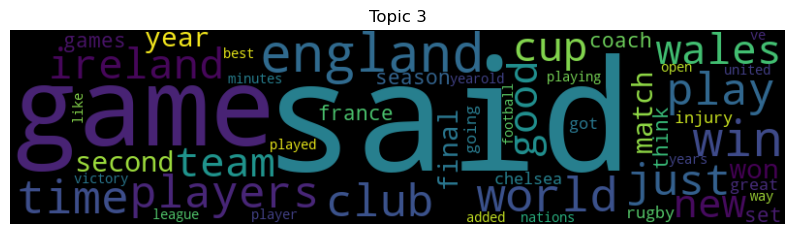

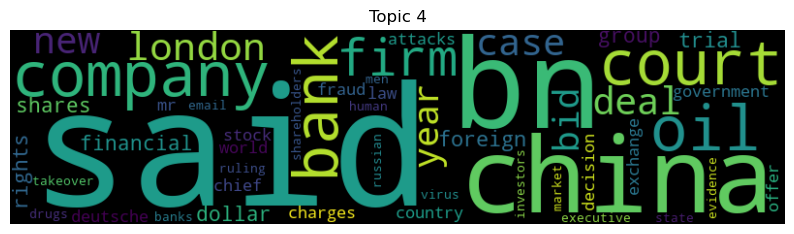

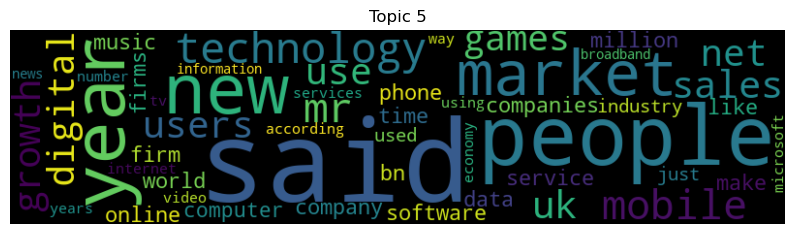

In [26]:
for topic_idx, topic in enumerate(lda.components_):
    topic_words = {feature_names[i]: topic[i]
        for i in topic.argsort()[-50:]}

    wordcloud = WordCloud(
        width=800,
        height=200,
        background_color='black').generate_from_frequencies(topic_words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_idx + 1}")
    plt.show()


## Qualitative Evaluation of LDA Topics using Crosstabulation

In [27]:
pd.crosstab(df['label_text'], sub_df['topic_name'])

topic_name,"Business, Finance & Legal Affairs",Entertainment & Film Awards,Politics & Government,Sports & Games,Technology & Market Trends
label_text,,,,,
business,147,3,98,0,262
entertainment,3,358,14,0,11
politics,18,2,395,0,2
sport,12,1,3,495,0
tech,11,10,12,4,364


In [30]:
import pickle

# Save LDA model
with open("lda_model.pkl", "wb") as f:
    pickle.dump(lda, f)

# Save vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(count_vectorizer, f)

# Save topic names
with open("topic_names.pkl", "wb") as f:
    pickle.dump(topic_name, f)
